In [1]:
### Import required libraries
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from IPython.display import clear_output
from sklearn import *
from tensorflow.examples.tutorials.mnist import input_data

mnist=input_data.read_data_sets('../../MNIST_data', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
### Global variables Initialization
e=2.7182818284590452353602874713527 
time_series_len = 1000                         # Length of the time-series
t_s = 0.35
T_split = int(t_s*time_series_len)            # Split point

o_l=0.05
outlier_len = int(time_series_len*o_l)      # Number of outliers

outlier_pos=random.sample(range(0,time_series_len-1),int(math.floor(outlier_len))) #positions of outliers in the timeseries

In [3]:
def sample(mb,data):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:mb]
    data_mb = [data[i] for i in idx]
    return np.asarray(data_mb)    


def sort(arrays):
    arrays.sort()
    return arrays


def plot_image(pixel):
    plt.imshow(np.reshape(pixel,[28,28]), cmap='gray')


def plot(array, label):
    t1 = range(len(array))
    _, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
    ax1.set_ylabel(label)
    ax1.plot(t1, array, 'b-', label='+')
    ax1.set_xlabel("Data Points")

    
def plot_2(array1, array2, label1, label2):
    t1 = range(len(array1))
    t2 = range(len(array2))
    _, (ax1,ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(t1, array1, 'b-', label='+')
    ax1.set_xlabel("Data Points")
    ax1.set_ylabel(label1)

    ax2.plot(t2, array2, 'b-', label='+')
    ax2.set_ylabel(label2)
    ax2.set_xlabel("Data Points")



    
def create_psd(std, cov, d):
    sigma1 =  np.random.uniform(std[0],std[1],size=d)         # Standard deviation --> P1 distribution 
    covar =  np.random.uniform(cov[0],cov[1],size=d)         # Standard deviation --> P1 distribution 
    C=np.zeros((d,d))
    for i in range (d):
        for j in range(d):
            if i==j:
                C[i,j]=abs(sigma1[i])
            else:
                C[i,j]=abs(covar[i])
    C= np.dot(C,C.transpose())
    return C

In [4]:
def initialize_parameters():
   
    ### Neural network parameters

    ### Tensorflow placeholders to input data
    X1 = tf.placeholder(tf.float32, shape=[1, None, d])    # Placeholder X1 
    X2 = tf.placeholder(tf.float32, shape=[1, None, d])    # Placeholder X2
    
    a0_1_f= tf.get_variable("a0_1_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_1_f= tf.get_variable("c0_1_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    a0_2_f= tf.get_variable("a0_2_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_2_f= tf.get_variable("c0_2_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    a0_3_f= tf.get_variable("a0_3_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_3_f= tf.get_variable("c0_3_f", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    
    a0_1_b= tf.get_variable("a0_1_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_1_b= tf.get_variable("c0_1_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    a0_2_b= tf.get_variable("a0_2_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_2_b= tf.get_variable("c0_2_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    a0_3_b= tf.get_variable("a0_3_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    c0_3_b= tf.get_variable("c0_3_b", shape=[1, n_hidden], trainable=True,
           initializer=tf.contrib.layers.xavier_initializer()) 
    
    init_fw=tuple([tf.contrib.rnn.LSTMStateTuple(a0_1_f,c0_1_f), tf.contrib.rnn.LSTMStateTuple(a0_2_f,c0_2_f), tf.contrib.rnn.LSTMStateTuple(a0_3_f,c0_3_f)])
    init_bw=tuple([tf.contrib.rnn.LSTMStateTuple(a0_1_b,c0_1_b), tf.contrib.rnn.LSTMStateTuple(a0_2_b,c0_2_b), tf.contrib.rnn.LSTMStateTuple(a0_3_b,c0_3_b)])

    keep_prob = tf.placeholder(tf.float32)    # Placeholder keep_prob
    learning_rate = tf.placeholder(tf.float32, shape=[]) #learning rate

    #seq_lens = tf.placeholder(tf.int32, [1])

  
    placeholders={
                   "X1":X1,
                   "X2":X2    
                  }
    

    return placeholders,learning_rate, init_fw, init_bw

In [5]:
def create_data(inlier_label=1, outlier_label=8, time_series_lenghth=time_series_len, outlier_percentage=o_l):
    
    no_of_outliers=int(o_l*time_series_len)
    no_of_inliers=time_series_len-no_of_outliers
    
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    
    X_test_inlier = np.asarray([X_test[i] for i in range(len(X_test)) if Y_test[i]== inlier_label])[:no_of_inliers]
    labels_inlier=np.ones((no_of_inliers, 1))*inlier_label
    inliers=np.concatenate((X_test_inlier, labels_inlier),axis=1)
    
    
    X_test_outlier = np.asarray([X_test[i] for i in range(len(X_test)) if Y_test[i]== outlier_label])[:no_of_outliers]
    labels_outlier=np.ones((no_of_outliers,1))*outlier_label
    outliers=np.concatenate((X_test_outlier, labels_outlier),axis=1)
    
    
    data=np.concatenate((inliers, outliers), axis=0)
    np.random.shuffle(data)
    
    time_series=data[:,:-1]
    labels=data[:,-1]
    
    
    for i in range(labels.shape[0]):
        if labels[i] ==inlier_label:
            labels[i]=0
        elif labels[i]==outlier_label:
            labels[i]=1

    outlier_pos=[i for i in range(labels.shape[0]) if labels[i]]
    
    return time_series, labels, outlier_pos

In [6]:
def normalize(time_series):
    time_series_norm=time_series-np.mean(time_series)
    time_series_norm=time_series_norm/np.std(time_series)
    return time_series_norm

def split(time_series_norm):
            ### Obtain mixture distributions by splitting time-series at T_split
    split1 = time_series_norm[:T_split]         # First Mixture Distribution --> split time-series at T_split
    split2 = time_series_norm[T_split:]         # Second Mixture Distribution --> split time-series at T_split
    return split1, split2

In [7]:
def mini_batch_param (split1, split2):
    mb_d_t1 = int(math.ceil(split1.shape[0]/mb_n))
    mb_d_t2 = int(math.ceil(split2.shape[0]/mb_n))
    batch_number_t1=math.ceil(split1.shape[0]/mb_d_t1)
    idx_t1=np.arange(0,batch_number_t1)
    np.random.shuffle(idx_t1)
    batch_number_t2=math.ceil(split1.size/mb_d_t2)
    idx_t2=np.arange(0,batch_number_t1)
    np.random.shuffle(idx_t2)
    return idx_t1, idx_t2, mb_d_t1,mb_d_t2

def mini_batch(data,idx, i,mb_s):
    last_full_batch=math.floor(data.shape[0]/mb_s)
    j=idx[i]
    if j<last_full_batch:
        return np.reshape(pad(data[j*mb_s:(j+1)*mb_s,:]), (1, -1, d))
    else:
        return  np.reshape(pad(data[j*mb_s:,:]), (1, -1, d))


In [8]:
def pad(array):
    padding=np.zeros((padding_size, array.shape[1]))
    return np.concatenate((padding, array, padding))

In [9]:
def cusum(array):
    x=np.zeros(array.shape)
    x[0]=array[0]
    for i in range(1, len(list(array))):
        x[i]=x[i-1]+array[i]
    return x

In [10]:
def lstm_cell():
        lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, state_is_tuple=True)
        return lstm
    
    
def RNN(x, init_fw, init_bw):

    
    cell_fw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_LSTM_layers)])
    cell_bw = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_LSTM_layers)])
        
    

    rnn_outputs, final_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, 
                                                               x, 
                                                                sequence_length=None,
                                                               initial_state_fw=init_fw,initial_state_bw=init_bw
                                                              )
    
    
    
    outputs_fw, outputs_bw= rnn_outputs
    
    output=tf.concat((outputs_fw[0], outputs_bw[0]), axis=1)
    fclayer1=tf.nn.sigmoid(tf.layers.dense(output, 0.5*n_hidden))
    fclayer2=tf.nn.sigmoid(tf.layers.dense(fclayer1, 0.25*n_hidden))
    fclayer3=tf.nn.softplus(tf.layers.dense(fclayer2, 1))
    

    return tf.reshape(fclayer3, [-1, 1])

In [11]:
def train(NN_solver, time_series, train_it):
    
    time_series_norm=normalize(time_series)
    split1, split2=split(time_series_norm)
    
    idx_t1, idx_t2, mb_d_t1,mb_d_t2=mini_batch_param (split1, split2)
    lss=[]
    ### Neural Network Training
    for it in range(train_it):
        
        np.random.shuffle(idx_t1),np.random.shuffle(idx_t2)
        
        for i in range(mb_n):
            
            lr=0.001
            _,loss = sess.run([NN_Solver, NN_Loss], feed_dict={X1: mini_batch(split1,idx_t1, i,mb_d_t1), X2: mini_batch(split2,idx_t2, i,mb_d_t2), learning_rate:lr })
            lss.append(loss)
       
        print("Loss at", it, "is", loss)
    
    clear_output()
    plot(lss, "Loss progress")
    
    time_series_norm=normalize(time_series)
    padded_time_series=pad(time_series_norm)
    padded_time_series=np.reshape(padded_time_series, (1, -1, d))


    NN_out = sess.run(NN_Out_X1,feed_dict={X1: padded_time_series})

    return NN_out

            
    

In [12]:
def detect_outliers(NN, outlier_pos):
    
    detected_outliers=[]
    
    NN=list(NN)
    NN_sorted=NN.copy()
    
    mean, std=np.mean(NN), np.std(NN)
    minimum=min(NN)
    maximum=max(NN)
    detected_outliers=[]
    if ((maximum-mean)>(mean-minimum)):
        print('Mode: ridge')
        NN_sorted.sort(reverse=True)
    elif  ((maximum-mean)<(mean-minimum)):
        print('Mode: valley')
        NN_sorted.sort()
        
    for i in range (int(0.5*o_l*len(NN))):
        detected_outliers.append(NN.index(NN_sorted[i]))
        NN[NN.index(NN_sorted[i])]+=1e-4

    print(len(detected_outliers), "Detected outliers: \n",detected_outliers)
    print(len(outlier_pos), "Actual outliers:  \n",sort(outlier_pos))
    return detected_outliers

In [13]:
def remove_outliers(time_series, labels, detected_outliers):
    time_list=[]
    labels_list=[]
    outliers_list=[]
    for i in range(np.shape(time_series)[0]):
        if i in detected_outliers:
            continue
        else:
            time_list.append(time_series[i])
            labels_list.append(labels[i])
    for i in range (len(labels_list)):
        if labels_list[i]==1:
            outliers_list.append(i)

    return time_list, labels_list, outliers_list

In [14]:
def calculate_error(detected_outliers, outlier_pos):
    er=0
    count=0
    correct=[]
    wrong=[]
    for i in detected_outliers:
        if (i in outlier_pos):
            er+=1
            correct.append(i)
        else: 
            wrong.append(i)
    print(len(correct),"Correctly Guessed samples", correct)
    print(len(wrong), "Wrongly Guessed samples.", wrong)
    
 
    false_negative=1-er/len(outlier_pos)
    print("False Negative: ",false_negative*100, "%")


In [15]:
def swap(detected_outliers,time_series, labels):
    time_list=[]
    outliers=[]
    labels_1=[]
    labels_2=[]
    for i in range(np.shape(time_series)[0]):
        if i in detected_outliers:
            outliers.append(time_series[i])
            labels_1.append(labels[i])
        else:
            time_list.append(time_series[i])
            labels_2.append(labels[i])

    swapped_time_list=np.concatenate((outliers, time_list))
    swapped_labels=np.concatenate((labels_1, labels_2))
    
    swapped_outlier_pos=[i for i in range(len(swapped_labels)) if swapped_labels[i]==1]
    
    return swapped_time_list, swapped_labels,  swapped_outlier_pos

In [16]:
tf.reset_default_graph()
lambda_1 = 2                               # Optimization Fn parameter
n_hidden=64                                    #numer_of_batches
num_LSTM_layers=3
padding_size=25
mb_n=5
### create_example
time_series, labels, outlier_pos=create_data(1,7)

d = time_series.shape[1]                                      # Dimension of each sample


### initialize parameters and placeholders
placeholders, learning_rate, init_fw, init_bw=initialize_parameters ()

X1,X2=placeholders["X1"],placeholders["X2"]



with tf.variable_scope('NN_Out_X1'):
           NN_Out_X1=RNN(X1, init_fw, init_bw)
with tf.variable_scope('NN_Out_X2'):
           NN_Out_X2=RNN(X2, init_fw, init_bw)

                
### Neural Network Loss for Deep Learning based Density Ratio Estimator
NN_Loss1 = tf.reduce_mean(tf.log(NN_Out_X1+0.0000000000001))
NN_Loss2  = lambda_1 *(tf.reduce_mean(NN_Out_X2)-1)

NN_Loss = NN_Loss1 - NN_Loss2

### Maximize NN_Loss over Neural Net parameters through Adam Optimizer 




optimizer = tf.train.AdamOptimizer(learning_rate)

gradient_var_pairs = optimizer.compute_gradients(-NN_Loss)
vars = [x[1] for x in gradient_var_pairs]
gradients = [x[0] for x in gradient_var_pairs]

clipped, _ = tf.clip_by_global_norm(gradients, 5)

NN_Solver = optimizer.apply_gradients(zip(clipped, vars))
#NN_Solver= tf.train.AdamOptimizer(learning_rate).minimize(-NN_Loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Mode: valley
25 Detected outliers: 
 [319, 297, 612, 323, 261, 942, 782, 315, 353, 501, 398, 663, 569, 829, 128, 658, 531, 318, 515, 624, 855, 999, 154, 430, 302]
50 Actual outliers:  
 [0, 66, 67, 82, 128, 189, 211, 217, 232, 255, 261, 262, 297, 315, 318, 319, 323, 340, 417, 423, 430, 445, 484, 515, 531, 537, 557, 569, 577, 589, 590, 612, 640, 651, 658, 669, 673, 732, 758, 770, 782, 787, 839, 890, 937, 942, 957, 984, 991, 998]
15 Correctly Guessed samples [319, 297, 612, 323, 261, 942, 782, 315, 569, 128, 658, 531, 318, 515, 430]
10 Wrongly Guessed samples. [353, 501, 398, 663, 829, 624, 855, 999, 154, 302]
False Negative:  70.0 %
Remaining Outliers: [0, 66, 67, 82, 187, 209, 215, 230, 253, 259, 331, 406, 412, 433, 472, 522, 542, 561, 573, 574, 622, 633, 649, 653, 712, 738, 750, 766, 817, 867, 914, 933, 960, 967, 974]


<bound method BaseSession.close of <tensorflow.python.client.session.Session object at 0x00000289C0018748>>

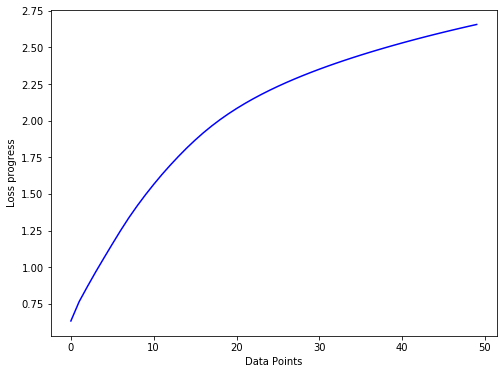

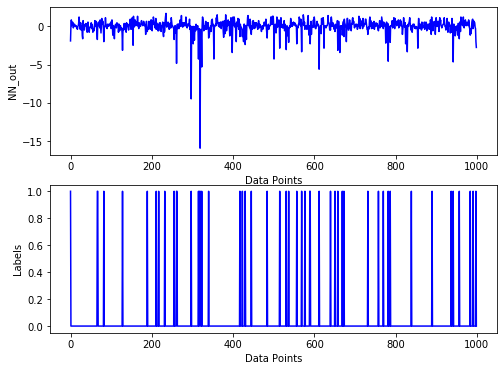

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

NN_out=train(NN_Solver, time_series, 10)
#plot_2(NN_out,labels, 'NN_out', "Labels")

NN_out_cutoff=normalize(NN_out[padding_size:-padding_size])

#NN_out_cutoff=np.asarray(list(np.ones(5)*np.mean(NN_out_cutoff[5:-5]))+list(NN_out_cutoff[5:-5])+list(np.ones(5)*np.mean(NN_out_cutoff[5:-5])))


plot_2(NN_out_cutoff,labels, 'NN_out', "Labels")

detected_outliers=detect_outliers(NN_out_cutoff,  outlier_pos)
detected_time_series, detected_labels, remaining_outliers= remove_outliers(np.reshape(time_series,[time_series_len, -1]), labels,detected_outliers)

first=[detected_time_series, detected_labels, remaining_outliers]

calculate_error(detected_outliers,outlier_pos)

print("Remaining Outliers:" , remaining_outliers)
sess.close

975
975
Mode: valley
24 Detected outliers: 
 [974, 522, 542, 0, 973, 574, 622, 766, 66, 750, 804, 867, 633, 370, 816, 659, 756, 331, 875, 332, 967, 367, 933, 406]
35 Actual outliers:  
 [0, 66, 67, 82, 187, 209, 215, 230, 253, 259, 331, 406, 412, 433, 472, 522, 542, 561, 573, 574, 622, 633, 649, 653, 712, 738, 750, 766, 817, 867, 914, 933, 960, 967, 974]
15 Correctly Guessed samples [974, 522, 542, 0, 574, 622, 766, 66, 750, 867, 633, 331, 967, 933, 406]
9 Wrongly Guessed samples. [973, 804, 370, 816, 659, 756, 875, 332, 367]
False Negative:  57.14285714285714 %
Remaining Outliers: [65, 80, 185, 207, 213, 228, 251, 257, 405, 426, 465, 552, 564, 637, 641, 699, 725, 799, 894, 939]


<bound method BaseSession.close of <tensorflow.python.client.session.Session object at 0x00000289C9ECF630>>

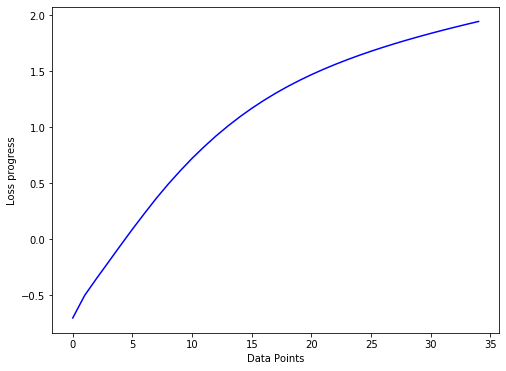

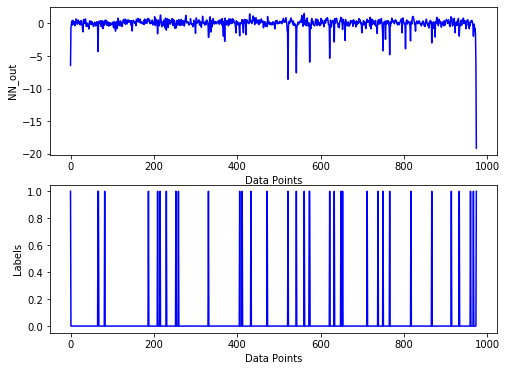

In [18]:

                
### Neural Network Loss for Deep Learning based Density Ratio Estimator
detected_time_series, detected_labels, remaining_outliers=first



sess = tf.Session()
sess.run(tf.global_variables_initializer())

NN_out=train(NN_Solver, detected_time_series, 7)

NN_out_cutoff=normalize(NN_out[padding_size:-padding_size])

#NN_out_cutoff=np.asarray(list(np.ones(5)*np.mean(NN_out_cutoff[5:-5]))+list(NN_out_cutoff[5:-5])+list(np.ones(5)*np.mean(NN_out_cutoff[5:-5])))


print(len(NN_out_cutoff))
print(len(detected_labels))
plot_2(NN_out_cutoff,detected_labels, 'NN_out', "Labels")

detected_outliers=detect_outliers(NN_out_cutoff,  remaining_outliers)

calculate_error(detected_outliers,remaining_outliers)

detected_time_series, detected_labels, remaining_outliers= remove_outliers(detected_time_series, detected_labels,detected_outliers)

second=[detected_time_series, detected_labels, remaining_outliers]

print("Remaining Outliers:" , remaining_outliers)

sess.close

In [ ]:

                
### Neural Network Loss for Deep Learning based Density Ratio Estimator
detected_time_series, detected_labels, remaining_outliers=second



sess = tf.Session()
sess.run(tf.global_variables_initializer())

NN_out=train(NN_Solver, detected_time_series, 7)

NN_out_cutoff=normalize(NN_out[padding_size:-padding_size])

#NN_out_cutoff=np.asarray(list(np.ones(5)*np.mean(NN_out_cutoff[5:-5]))+list(NN_out_cutoff[5:-5])+list(np.ones(5)*np.mean(NN_out_cutoff[5:-5])))


print(len(NN_out_cutoff))
print(len(detected_labels))
plot_2(NN_out_cutoff,detected_labels, 'NN_out', "Labels")

detected_outliers=detect_outliers(NN_out_cutoff,  remaining_outliers)

calculate_error(detected_outliers,remaining_outliers)

detected_time_series, detected_labels, remaining_outliers= remove_outliers(detected_time_series, detected_labels,detected_outliers)

third=[detected_time_series, detected_labels, remaining_outliers]
print("Remaining Outliers:" , remaining_outliers)


sess.close

In [ ]:

                
### Neural Network Loss for Deep Learning based Density Ratio Estimator

detected_time_series, detected_labels, remaining_outliers=third


sess = tf.Session()
sess.run(tf.global_variables_initializer())

NN_out=train(NN_Solver, detected_time_series, 7)

NN_out_cutoff=normalize(NN_out[padding_size:-padding_size])

#NN_out_cutoff=np.asarray(list(np.ones(5)*np.mean(NN_out_cutoff[5:-5]))+list(NN_out_cutoff[5:-5])+list(np.ones(5)*np.mean(NN_out_cutoff[5:-5])))


print(len(NN_out_cutoff))
print(len(detected_labels))
plot_2(NN_out_cutoff,detected_labels, 'NN_out', "Labels")

detected_outliers=detect_outliers(NN_out_cutoff,  remaining_outliers)

calculate_error(detected_outliers,remaining_outliers)

detected_time_series, detected_labels, remaining_outliers= remove_outliers(detected_time_series, detected_labels,detected_outliers)

fouth=[detected_time_series, detected_labels, remaining_outliers]
print("Remaining Outliers:" , remaining_outliers)


sess.close

In [ ]:
print(len(remaining_outliers))

In [22]:
print(len(detected_time_series))

905


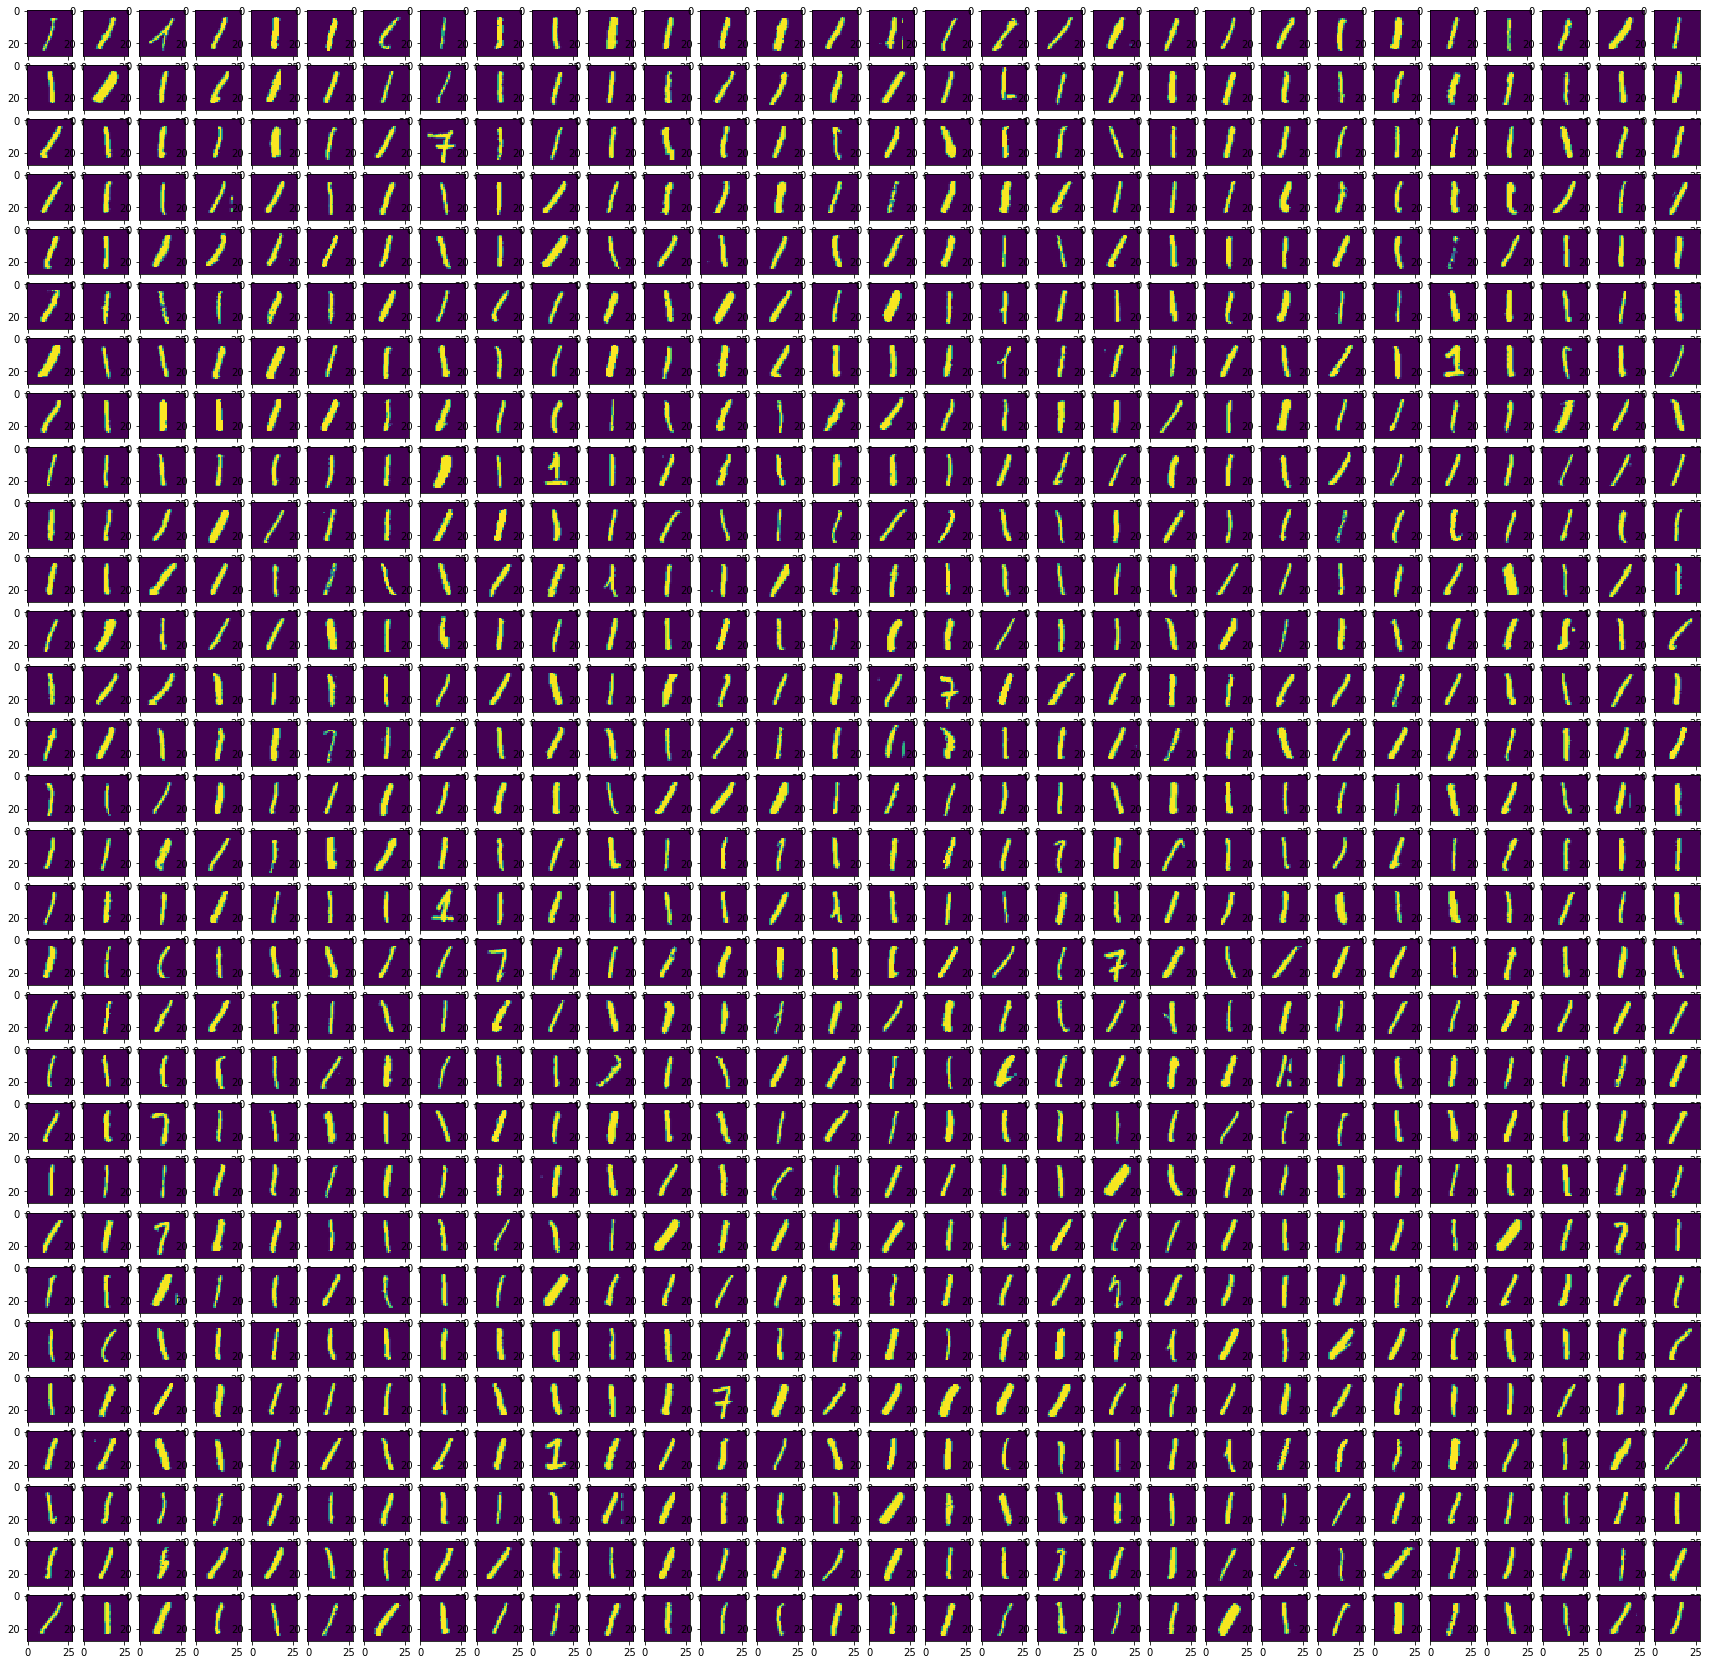

In [23]:
w=10
h=10
fig=plt.figure(figsize=(30, 30))
columns = 30
rows = 30
for i in range(1, columns*rows +1):
    img = np.reshape(detected_time_series[i], [28,28])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

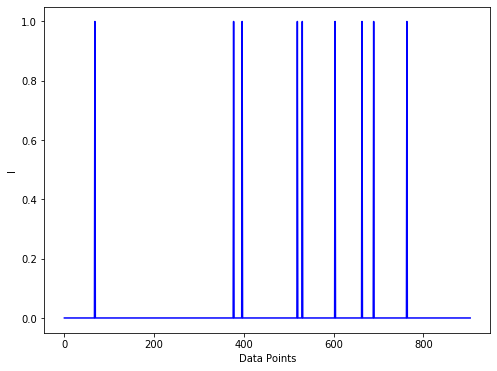

In [24]:
plot(detected_labels, "l")